# Exemplo Prática Ciência de Dados

### A Administração de Seguridade Social dos Estados Unidos (SSA) disponibilizou dados sobre a frequência de nomes de bebês de 1880 até o presente. Neste exemplo, vamos usar de

#### Há muitas coisas que você pode querer fazer com o conjunto de dados:
#### • Visualize a proporção de bebês com um nome específico (o seu próprio ou outro nome) ao longo do tempo
#### • Determinar a classificação relativa de um nome
#### • Determine os nomes mais populares em cada ano ou os nomes cuja popularidade avançou ou declinou mais
#### • Analisar tendências em nomes: vogais, consoantes, comprimento, diversidade geral, mudanças no ortografia, primeiras e últimas letras
#### • Analisar fontes externas de tendências: nomes bíblicos, celebridades, dados demográficos mudanças

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
url1 = "https://raw.githubusercontent.com/rlrocha90/IAeML-Treinamento/main/names1.csv"
url2 = "https://raw.githubusercontent.com/rlrocha90/IAeML-Treinamento/main/names2.csv"
url3 = "https://raw.githubusercontent.com/rlrocha90/IAeML-Treinamento/main/names3.csv"
url4 = "https://raw.githubusercontent.com/rlrocha90/IAeML-Treinamento/main/names4.csv"
names1 = pd.read_csv(url1)
names2 = pd.read_csv(url2)
names3 = pd.read_csv(url3)
names4 = pd.read_csv(url4)
names = []
names.append(names1)
names.append(names2)
names.append(names3)
names.append(names4)
names = pd.concat(names, axis=0, ignore_index=True)

In [19]:
names.head()

,Unnamed: 0,name,sex,births,year
0,0,Mary,F,7065,1880
1,1,Anna,F,2604,1880
2,2,Emma,F,2003,1880
3,3,Elizabeth,F,1939,1880
4,4,Minnie,F,1746,1880


#### Com esses dados em mãos, já podemos começar a agregar os dados no nível de ano e sexo usando groupby ou pivot_table
#### PivotTable para agregar (somar) os nascimentos por ano e sexo

<ipython-input-20-9e0e50924a23>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)


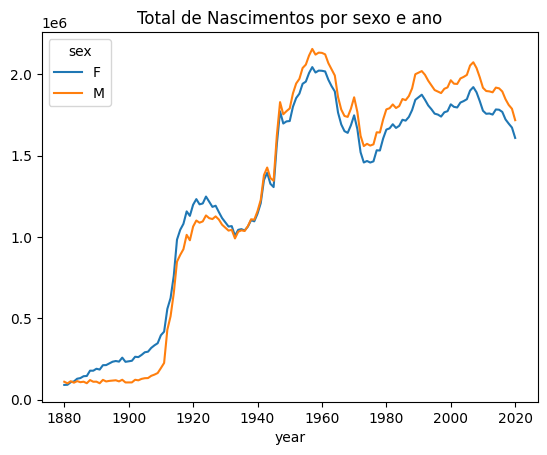

In [20]:
total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)
total_births.plot(title='Total de Nascimentos por sexo e ano')
plt.show()

#### Em seguida, vamos inserir um suporte de coluna com a fração de bebês com cada nome em relação ao número
#### total de nascimentos. Um valor prop de 0,02 indicaria que 2 em cada 100 bebês receberam um nome específico.
#### Assim, agrupamos os dados por ano e sexo e adicionamos a nova coluna a cada grupo:

In [21]:
def add_prop(group):
    group["prop"] = group["births"] / group["births"].sum()
    return group

names = names.groupby(["year", "sex"]).apply(add_prop)

<ipython-input-21-e0b52d1728a2>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  names = names.groupby(["year", "sex"]).apply(add_prop)


#### O conjunto de dados completo resultante agora tem as seguintes colunas:

In [22]:
print(names)

                  Unnamed: 0       name sex  births  year      prop
year sex                                                           
1880 F   0                 0       Mary   F    7065  1880  0.077642
         1                 1       Anna   F    2604  1880  0.028617
         2                 2       Emma   F    2003  1880  0.022012
         3                 3  Elizabeth   F    1939  1880  0.021309
         4                 4     Minnie   F    1746  1880  0.019188
...                      ...        ...  ..     ...   ...       ...
2020 M   1983000      926677     Zykell   M       5  2020  0.000003
         1983001      926678      Zylus   M       5  2020  0.000003
         1983002      926679     Zymari   M       5  2020  0.000003
         1983003      926680        Zyn   M       5  2020  0.000003
         1983004      926681      Zyran   M       5  2020  0.000003

[1983005 rows x 6 columns]


#### Ao realizar uma operação de grupo como esta, geralmente é valioso fazer uma verificação de sanidade,
#### como verificar se a coluna prop soma 1 em todos os grupos:

In [25]:
names = names.reset_index(drop=True)
print(names.groupby(["year", "sex"])["prop"].sum())

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2018  M      1.0
2019  F      1.0
      M      1.0
2020  F      1.0
      M      1.0
Name: prop, Length: 276, dtype: float64


#### Agora que isso está feito, vou extrair um subconjunto dos dados para facilitar uma análise mais aprofundada:
#### os 1.000 principais nomes para cada combinação de sexo/ano. Esta é mais uma operação de grupo:

In [26]:
def get_top1000(group):
    return group.sort_values("births", ascending=False)[:1000]

grouped = names.groupby(["year", "sex"])
top1000 = grouped.apply(get_top1000)
top1000 = top1000.reset_index(drop=True)

<ipython-input-26-c65ff4f29a0c>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top1000 = grouped.apply(get_top1000)


#### O conjunto de dados resultante agora é um pouco menor:

In [27]:
print(top1000.head())

   Unnamed: 0       name sex  births  year      prop
0           0       Mary   F    7065  1880  0.077642
1           1       Anna   F    2604  1880  0.028617
2           2       Emma   F    2003  1880  0.022012
3           3  Elizabeth   F    1939  1880  0.021309
4           4     Minnie   F    1746  1880  0.019188


### Analisando tendências de nomes
#### Com o conjunto de dados completo e o conjunto de dados Top 1.000 em mãos, podemos começar
#### a analisar várias tendências de nomes de interesse. Dividir os 1.000 principais nomes nas partes de menino e menina é fácil de fazer primeiro:

In [28]:
boys = top1000[top1000["sex"] == "M"]
girls = top1000[top1000["sex"] == "F"]

#### Séries temporais simples, como o número de Johns ou Marys para cada ano, podem ser plotadas, mas requerem
#### um pouco de atenção para serem mais úteis. Vamos formar uma tabela dinâmica do número total de nascimentos por ano e nome:

In [29]:
total_births = top1000.pivot_table("births", index="year", columns="name", aggfunc=sum)

<ipython-input-29-e993f2254386>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_births = top1000.pivot_table("births", index="year", columns="name", aggfunc=sum)


#### Agora, isso pode ser plotado para um punhado de nomes com o método de plotagem do DataFrame

---- informações do Total de Nascimento ----
<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 1880 to 2020
Columns: 7232 entries, Aaden to Zyon
dtypes: float64(7232)
memory usage: 7.6 MB
None


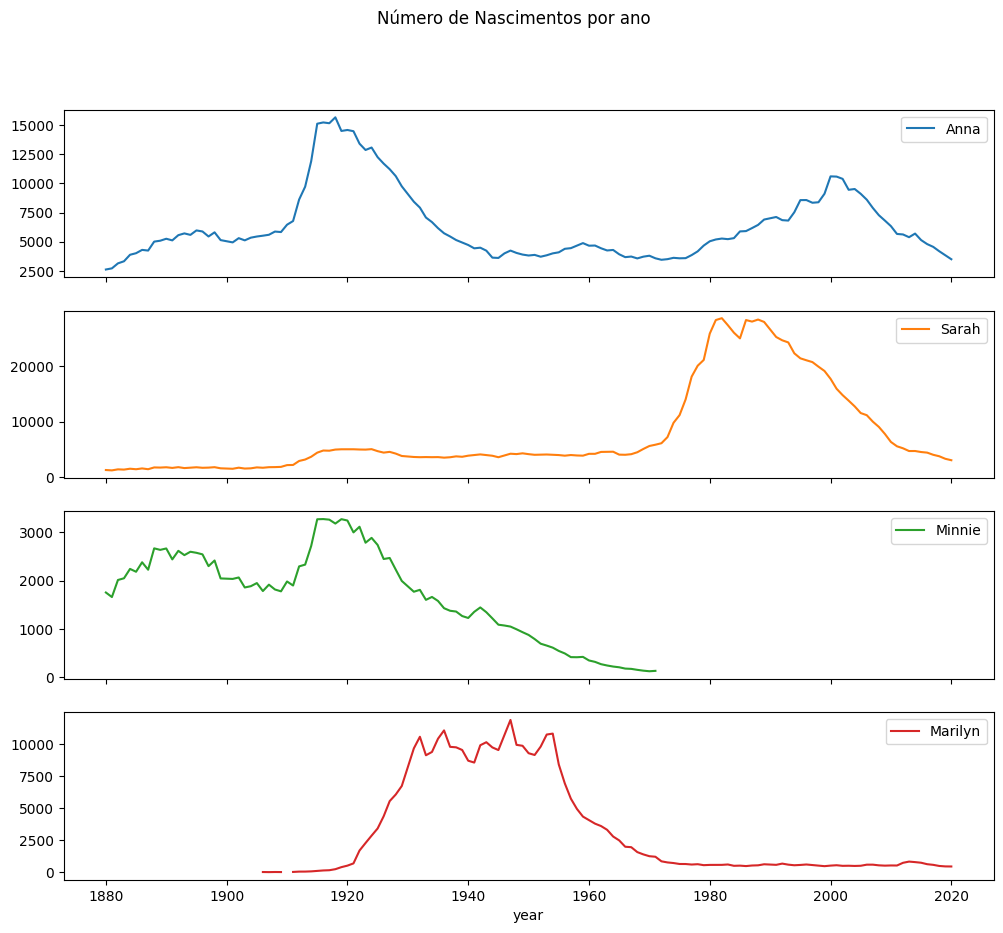

In [30]:
print("---- informações do Total de Nascimento ----")
print(total_births.info())
subset = total_births[["Anna", "Sarah", "Minnie", "Marilyn"]]
subset.plot(subplots=True, figsize=(12, 10), title="Número de Nascimentos por ano")
plt.show()

#### Ao olhar para isso, você pode concluir que esses nomes cresceram em desuso com a população americana. Mas a história é realmente mais complicada do que isso, como será explorado na próxima seção.

### Medindo o aumento na diversidade de nomes
#### Uma explicação para a diminuição das parcelas é que menos pais estão escolhendo nomes comuns para seus filhos.
#### Essa hipótese pode ser explorada e confirmada nos dados. Uma medida é a proporção de nascimentos representados pelos 1.000 nomes mais populares, que eu agrego e gravo por ano e sexo

<ipython-input-31-30154a649aca>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc=sum)


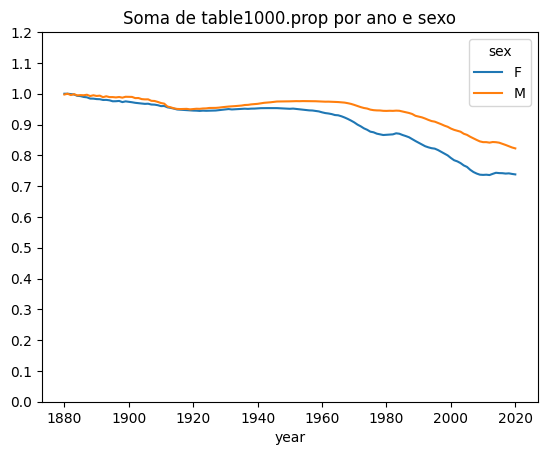

In [31]:
table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc=sum)
table.plot(title="Soma de table1000.prop por ano e sexo", yticks=np.linspace(0, 1.2, 13))
plt.show()

#### Você pode ver que, de fato, parece estar aumentando a diversidade de nomes (diminuindo a proporção total no top 1.000). Outra métrica interessante é o número de nomes distintos, em ordem de popularidade, do mais alto para o mais baixo, nos 50% melhores nascimentos. Este número é um pouco mais complicado de calcular. Vamos considerar apenas os nomes de meninos de 2010:

In [32]:
df = boys[boys["year"] == 2010]
print(df)

        Unnamed: 0     name sex  births  year      prop
254876      583568    Jacob   M   22139  2010  0.011546
254877      583569    Ethan   M   18008  2010  0.009392
254878      583570  Michael   M   17366  2010  0.009057
254879      583571   Jayden   M   17191  2010  0.008966
254880      583572  William   M   17060  2010  0.008897
...            ...      ...  ..     ...   ...       ...
255871      584563   Bailey   M     196  2010  0.000102
255872      584564   Destin   M     196  2010  0.000102
255873      584565  Eliezer   M     196  2010  0.000102
255874      584566    Enoch   M     196  2010  0.000102
255875      584567   Joziah   M     196  2010  0.000102

[1000 rows x 6 columns]


#### Depois de classificar prop em ordem decrescente, queremos saber quantos dos nomes mais populares são necessários para chegar a 50%. Você poderia escrever um loop for para fazer isso, mas uma maneira NumPy vetorizada é um pouco mais inteligente. Pegar a soma cumulativa, cumsum, de prop e então chamar o método searchsorted retorna a posição na soma cumulativa na qual 0.5 precisaria ser inserido para mantê-la em ordem:

254876    0.011546
254877    0.020938
254878    0.029995
254879    0.038961
254880    0.047858
254881    0.056599
254882    0.065185
254883    0.073453
254884    0.081559
254885    0.089644
Name: prop, dtype: float64


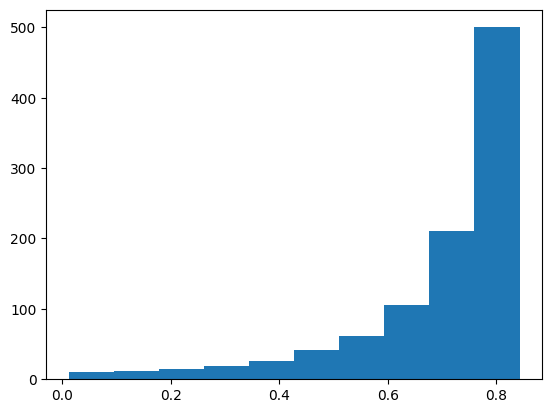

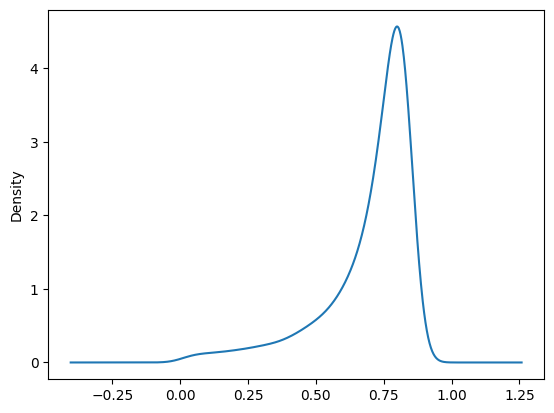

116


In [33]:
prop_cumsum = df["prop"].sort_values(ascending=False).cumsum()
print(prop_cumsum[0:10])
plt.hist(prop_cumsum)
plt.show()
prop_cumsum.plot.density()
plt.show()
print(prop_cumsum.searchsorted(0.5))

#### Como as matrizes são indexadas a zero, adicionar 1 a esse resultado resulta em 117. Em contraste, em 1900 esse número era muito menor:

In [34]:
df = boys[boys.year == 1900]
in1900 = df.sort_values("prop", ascending=False).prop.cumsum()
print(in1900.searchsorted(0.5) + 1)

1


#### Agora você pode aplicar esta operação a cada combinação de ano/sexo, agrupar por esses campos e aplicar uma função que retorna a contagem para cada grupo:

In [35]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values("prop", ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(["year", "sex"]).apply(get_quantile_count)
diversity = diversity.unstack()

<ipython-input-35-94252a958cf6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversity = top1000.groupby(["year", "sex"]).apply(get_quantile_count)


#### Essa diversidade de DataFrame resultante agora tem duas séries temporais, uma para cada sexo, indexadas por ano.

sex    F   M
year        
1880  38  14
1881  38  14
1882  38  15
1883  39  15
1884  39  16


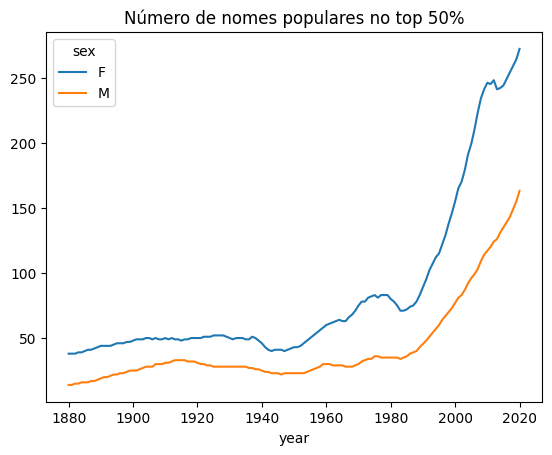

In [36]:
print(diversity.head())
diversity.plot(title="Número de nomes populares no top 50%")
plt.show()

#### Como você pode ver, os nomes das meninas sempre foram mais diversos do que os nomes dos meninos, e eles só se tornaram mais ao longo do tempo. Uma análise mais aprofundada do que exatamente está impulsionando a diversidade, como o aumento de grafias alternativas, é deixada para o leitor.

### A revolução da “última letra”
#### Em 2007, a pesquisadora de nomes de bebês Laura Wattenberg apontou em seu site que a distribuição de nomes de meninos por letra final mudou significativamente nos últimos 100 anos. Para ver isso, primeiro agregamos todos os nascimentos no conjunto de dados completo por ano, sexo e letra final:

In [37]:
def get_last_letter(x):
    return x[-1]

last_letters = names["name"].map(get_last_letter)
last_letters.name = "last_letter"

table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc=sum)

<ipython-input-37-cae264d0338d>:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc=sum)


#### Em seguida, selecionamos três anos representativos abrangendo o histórico e imprimimos as primeiras linhas:

In [38]:
subtable = table.reindex(columns=[1910, 1960, 2010, 2020], level="year")
print(subtable.head())

sex                 F                                      M            \
year             1910      1960      2010      2020     1910      1960   
last_letter                                                              
a            108399.0  691285.0  677176.0  614720.0    977.0    5214.0   
b                 NaN     694.0     455.0     530.0    411.0    3910.0   
c                 5.0      49.0     957.0     892.0    482.0   15456.0   
d              6751.0    3732.0    2645.0    3810.0  22112.0  262106.0   
e            133601.0  435009.0  316921.0  285170.0  28665.0  178742.0   

sex                              
year             2010      2020  
last_letter                      
a             28888.0   33800.0  
b             39298.0   18067.0  
c             23360.0   16652.0  
d             44856.0   38875.0  
e            130325.0  116438.0  


#### Em seguida, normalize a tabela pelo total de nascimentos para calcular uma nova tabela contendo a proporção do total de nascimentos para cada sexo terminando em cada letra:

In [39]:
print(subtable.sum())
letter_prop = subtable / subtable.sum()
print(letter_prop)

sex  year
F    1910     396505.0
     1960    2022001.0
     2010    1776223.0
     2020    1609171.0
M    1910     194209.0
     1960    2131990.0
     2010    1917416.0
     2020    1718248.0
dtype: float64
sex                 F                                       M            \
year             1910      1960      2010      2020      1910      1960   
last_letter                                                               
a            0.273386  0.341882  0.381245  0.382010  0.005031  0.002446   
b                 NaN  0.000343  0.000256  0.000329  0.002116  0.001834   
c            0.000013  0.000024  0.000539  0.000554  0.002482  0.007250   
d            0.017026  0.001846  0.001489  0.002368  0.113857  0.122940   
e            0.336947  0.215138  0.178424  0.177215  0.147599  0.083838   
f                 NaN  0.000010  0.000055  0.000100  0.000783  0.004330   
g            0.000144  0.000157  0.000377  0.000441  0.002260  0.009489   
h            0.051530  0.036223  0.075998

#### Com as proporções das letras agora em mãos, podemos fazer gráficos de barras para cada sexo divididos por ano

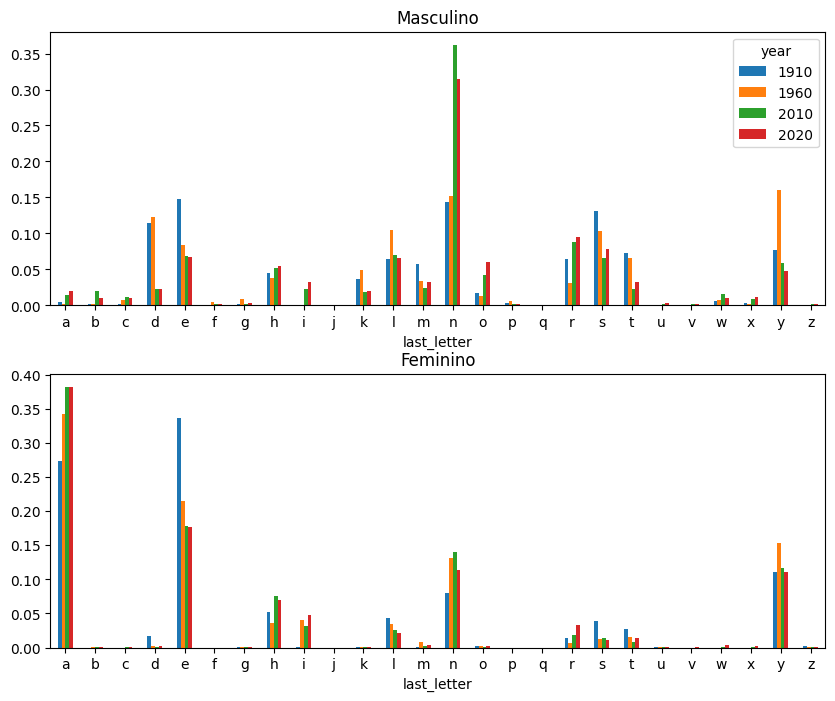

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop["M"].plot(kind="bar", rot=0, ax=axes[0], title="Masculino")
letter_prop["F"].plot(kind="bar", rot=0, ax=axes[1], title="Feminino",legend=False)
plt.subplots_adjust(hspace=0.25)
plt.show()

#### Como você pode ver, os nomes de meninos terminados em n tiveram um crescimento significativo desde a década de 1960. Voltando à tabela completa criada anteriormente, normalizo novamente por ano e sexo e seleciono um subconjunto de letras para os nomes dos meninos, finalmente transpondo para tornar cada coluna uma série temporal:

In [41]:
letter_prop = table / table.sum()

dny_ts = letter_prop.loc[["t", "n", "y"], "M"].T
print(dny_ts.head())

last_letter         t         n         y
year                                     
1880         0.062884  0.153217  0.075763
1881         0.061824  0.153221  0.077459
1882         0.062294  0.149561  0.077538
1883         0.064554  0.151656  0.079149
1884         0.061228  0.149927  0.080408


#### Com este DataFrame de séries temporais em mãos, posso fazer um gráfico das tendências ao longo do tempo novamente com seu método de plotagem

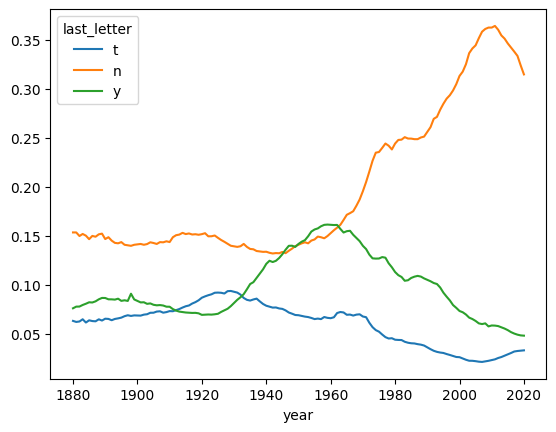

In [42]:
dny_ts.plot()
plt.show()

### Nomes de meninos que se tornaram nomes de meninas (e vice-versa)
#### Outra tendência divertida é olhar para nomes de meninos que eram mais populares com um sexo no início da amostra, mas que “mudaram de sexo” no presente. Um exemplo é o nome Lesley ou Leslie. Voltando ao top1000

In [43]:
all_names = pd.Series(top1000["name"].unique())
lesley_like = all_names[all_names.str.contains("Lesl")]
print(lesley_like)

632     Leslie
2293    Lesley
4251    Leslee
4720     Lesli
6092     Lesly
dtype: object


#### A partir daí, podemos filtrar apenas esses nomes e somar nascimentos agrupados por nome para ver as frequências relativas:

In [44]:
filtered = top1000[top1000["name"].isin(lesley_like)]
print(filtered.groupby("name")["births"].sum())

name
Leslee      1082
Lesley     34588
Lesli        929
Leslie    374448
Lesly      11433
Name: births, dtype: int64


#### Em seguida, vamos agregar por sexo e ano e normalizar dentro do ano:

In [45]:
table = filtered.pivot_table("births", index="year", columns="sex", aggfunc="sum")
table = table.div(table.sum(axis="columns"), axis="index")
table.tail()

sex,F,M
year,,
2016,1.0,NaN
2017,1.0,NaN
2018,1.0,NaN
2019,1.0,NaN
2020,1.0,NaN


#### Por fim, agora é possível fazer um gráfico da divisão por sexo ao longo do tempo

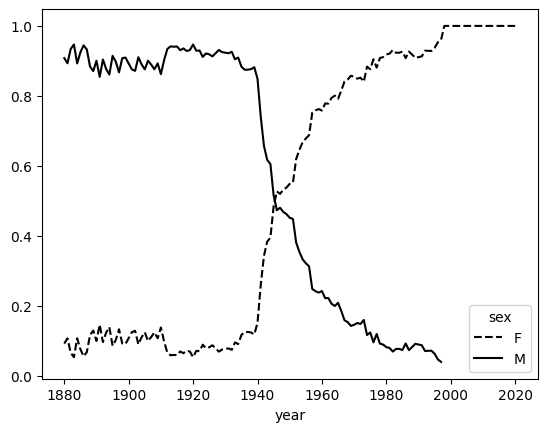

In [46]:
table.plot(style={"M": "k-", "F": "k--"})
plt.show()